## Plots graph edit distance figures in SI.

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import matplotlib.pyplot as plt
plt.rcParams.update({'font.family':'Arial'})
import numpy as np

import re

In [2]:
def sum_abs_adj_matrix(m):
    return sum(sum(np.abs(m)))/2

In [3]:
# synthia graph colors
synthia_purple = np.array([80,50,145,255])/255
synthia_blue = np.array([45,190,205,255])/255
synthia_orange = np.array([255,160,0,255])/255
synthia_pink = np.array([235,60,150,255])/255

In [4]:
# chemdraw step marker colors
cdraw_orange_face = np.array([252,236,207,255])/255
cdraw_orange_edge = np.array([245,191,94,255])/255

In [5]:
# gridline color
grid_grey = np.array([225,225,225,255])/255

## initialize

In [6]:
def process_route(r1):
    
    """
    processes matrix-encoded synthetic route.
    
    input: r1, a 3D array, where each layer is a matrix encoding a synthetic intermediate.
    output: a dictionary of route metrics. 
        diffs - the graph edit distance from each intermediate to the target
        step diffs - the graph edit distance from each intermediate to the one right after
        slope - the difference between consecutive entries of the diffs array
    """
    total_diffs = []

    stereo_dists = []
    final_stereo = np.diag(r1[-1].copy())
    
    # get a version with blank diagonals (since stereochem is processed separately)
    final_bonds = r1[-1].copy()
    np.fill_diagonal(final_bonds, 0)
    
    for raw_mat in r1:
        
        # calculate stereochem distance 
        stereo_data = np.diag(raw_mat.copy())
        stereo_dist = sum(stereo_data != final_stereo)
        stereo_dists.append(stereo_dist)
        
        # get bonds only (without stereo)
        mat = raw_mat.copy()
        np.fill_diagonal(mat, 0)
        
        # bond distance
        diff = final_bonds - mat
        
        # get bond edit distance
        # take all absolute values, sum them up, divide by 2
        total_diff_abs = sum_abs_adj_matrix(diff)
        
        # append sum of bond and stereochem distance
        total_diffs.append(total_diff_abs + stereo_dist)

    
    step_diffs = []
    stereo_diffs = np.ediff1d(stereo_dists)
    for i_mat in range(len(r1)-1):
        # difference between 2 intermediates
        step_diff = r1[i_mat+1] - r1[i_mat]
        
        # zero out the stereochem 
        np.fill_diagonal(step_diff, 0)
        
        # total bond and stereocenter edits between 2 consecutive intermediates 
        total_diff_abs = sum_abs_adj_matrix(step_diff) + abs(stereo_diffs[i_mat])

        step_diffs.append(total_diff_abs)

    # change in actual distance between intermediates 
    slope = -np.ediff1d(total_diffs)

    return {"diffs":total_diffs,"step_diffs":step_diffs,"slopes":slope}
    

In [7]:
def graph_data(input_filename, highlight_steps=[], hl_only=False,
               step_labels=None, table_scale=(0.3,1), gridlines=None, 
               savename=None,plt_title=None):
    
    """
    produces plot of graph edit distances for a synthetic route.
    
    inputs:
    
    input_filename: string, path to the .npz file of the synthetic route matrices
    
    hightlight_steps: list of step numbers to plot in orange.
    
    hl_only: boolean. Whether to only annotate step numbers for highlighted steps
    
    step_labels: list, used to override the default step labels
    
    table_scale: (x,y) tuple, scaling factor for the slope table. Set to None to omit.
    
    gridlines: a dictionary of {"x":[list of x indices],"y":[list of y indices]},
        where grey gridlines will be drawn at the indicated locations.
        
    savename: string, path to save figure image
    
    plt_title: string, for titling the graph.
    """
    amats = np.load(input_filename)["amats"]
    to_plot  = process_route(amats)["diffs"]

    # compute values for the slope table
    slope = -np.array(process_route(amats)["slopes"]).astype("int")
    
    # swap to em dash
    slope_plot = []
    for slp in slope:
        if slp >= 0:
            slope_plot.append(slp)
        else:
            slope_plot.append("−"+str(slp)[1:])

    # the case for a 4-column table
    if len(slope) >= 10:
        # even 
        if len(slope) % 2 == 0:
            table_tags = np.arange(1,len(slope)+1,1)
            table_midpt = int(len(slope)/2)
            table_text = np.column_stack((table_tags[0:table_midpt],
                                          slope_plot[0:table_midpt],
                                          table_tags[table_midpt:],
                                          slope_plot[table_midpt:]))
        # odd    
        else:
            slope1 = slope_plot + ["-"]
            table_tags = np.append(np.arange(1,len(slope1),1),"-")
            table_midpt = int(len(slope1)/2)
            table_text = np.column_stack((table_tags[0:table_midpt],
                                              slope1[0:table_midpt],
                                          table_tags[table_midpt:],
                                              slope1[table_midpt:]))        

    # regular
    else: 
        table_text = np.vstack((np.arange(1,len(slope)+1,1),slope_plot)).transpose()

    # for step numbers
    y_midpoints = np.array([np.mean([to_plot[i],to_plot[i+1]]) for i in range(len(to_plot)-1)])
    x_midpoints = np.arange(0.5,len(to_plot)-1,1)

    
    fig,ax = plt.subplots(figsize=(3.5,2))

    mks = 4
    fs = 11 # table and tick labels
    label_fs = 11 # axis labels
    circle_fs = 7
    
    # re-plot highlighted steps as orange
    ax.plot(to_plot,marker="o",markersize=mks,color="grey",mfc="k",mec="k")
    for hl in highlight_steps:
        ax.plot([hl-1,hl],to_plot[hl-1:hl+1],color=synthia_orange,marker="o",markersize=mks,mfc="k",mec="k",linewidth=2)
        
    if gridlines:
        transX = ax.get_xaxis_transform()
        transY = ax.get_yaxis_transform()
        ax.vlines(gridlines["x"],ymin=0,ymax=1,color=grid_grey,zorder=0,linewidth=0.8,transform=transX)
        ax.hlines(gridlines["y"],xmin=0,xmax=1,color=grid_grey,zorder=0,linewidth=0.8,transform=transY)

    # put in the table - colLabels will be fine with a 2-column.
    if table_scale:
        slope_table = ax.table(cellText=table_text,
                              colLabels=["Step","Slope","Step","Slope"],
                              loc='right',fontsize=fs)

        slope_table.scale(*table_scale)

    # the step circles
    y_adj = 0
    
    # if no override, the labels are just the step number
    if not step_labels:
        step_labels = range(1,len(slope)+1)

    # for only plotting the highlighted steps
    if hl_only:
        hl_inds = [i-1 for i in highlight_steps]
        ax.scatter(x_midpoints[hl_inds],y_midpoints[hl_inds]+y_adj,s=75,
                   color=cdraw_orange_face,edgecolors=cdraw_orange_edge,zorder=3)

        for hl in hl_inds:
            x_c = x_midpoints[hl]
            y_c = y_midpoints[hl]+y_adj
            label = ax.annotate(step_labels[hl], xy=(x_c,y_c), fontsize=circle_fs,ha="center",va="center",fontweight="bold")

    # for all the steps
    else:
        ax.scatter(x_midpoints,y_midpoints+y_adj,s=75,color=cdraw_orange_face,edgecolors=cdraw_orange_edge,zorder=3)

        for i in range(len(x_midpoints)):
            x_c = x_midpoints[i]
            y_c = y_midpoints[i]+y_adj

            label = ax.annotate(step_labels[i], xy=(x_c,y_c), fontsize=circle_fs,ha="center",va="center",fontweight="bold")

    # xy labels 
    ax.set_xticks(range(len(to_plot)))
    ax.set_xticklabels(range(1,len(to_plot)+1),fontsize=fs)
    
    y_max = np.int8( np.ceil(max(to_plot)/5) * 5 + 1 )
    ax.set_yticks(range(0,y_max,5))
    ax.set_yticklabels(range(0,y_max,5),font="Arial",fontsize=fs)

    ax.set_ylabel("Graph Edit Distance",fontsize=label_fs)
    ax.set_xlabel("Intermediate",fontsize=label_fs)
    
    if plt_title:
        plt.title(plt_title,fontsize=label_fs)
    
    if savename:
        plt.savefig(savename,dpi=600,bbox_inches = "tight")



### Stemoamide

### Synthia Mannich

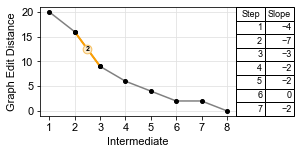

In [8]:
input_filename = "./matrices/stemo_synthia_mannich.npz"
highlight_steps = [2]
hl_only = True
step_labels = None

table_scale = (0.3,1.13)
gridlines = {"x":[1,3,5,7],"y":[0,5,10,15,20]}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/stemoamide_synthia_mannich.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, savename=savename)

### Experimental Mannich

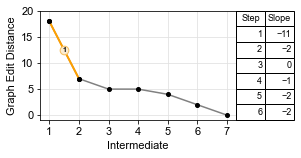

In [9]:
input_filename = "./matrices/stemo_exp_mannich.npz"
highlight_steps = [1]
hl_only = True
step_labels = None

table_scale = (0.3,1.3)
gridlines = {"x":range(7),"y":[0,5,10,15]}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/stemoamide_exp_mannich.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, savename=savename)

### Synthia Schmidt

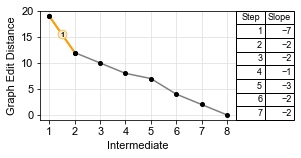

In [10]:
input_filename = "./matrices/stemo_synthia_schmidt.npz"
highlight_steps = [1]
hl_only = True
step_labels = None

table_scale = (0.3,1.14)
gridlines = {"x":range(8),"y":[0,5,10,15]}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/stemoamide_synthia_schmidt.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, savename=savename)

### Experimental Schmidt

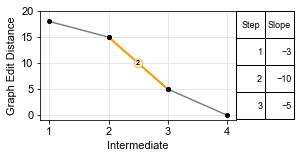

In [11]:
input_filename = "./matrices/stemo_exp_schmidt.npz"
highlight_steps = [2]
hl_only = True
step_labels = None

table_scale = (0.3,2.25)
gridlines = {"x":range(4),"y":[0,5,10,15]}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/stemoamide_exp_schmidt.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, savename=savename)

### Synthia with Mannich excluded

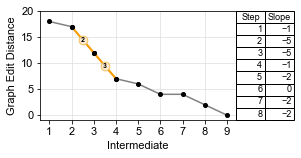

In [12]:
input_filename = "./matrices/stemo_synthia_no_mannich.npz"
highlight_steps = [2,3]
hl_only = True
step_labels = None

table_scale = (0.3,1.01)
gridlines = {"x":[1,3,5,7],"y":[0,5,10,15]}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/stemoamide_synthia_excl_Mannich.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, savename=savename)

### Stemonine Synthia

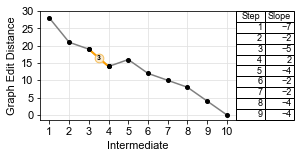

In [13]:
input_filename = "./matrices/stemonine_synthia.npz"
highlight_steps = [3]
hl_only = True
step_labels = None

table_scale = (0.3,0.91)
gridlines = {"x":[1,3,5,7,9],"y":[0,5,10,15,20,25]}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/{output_title}.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, savename=savename)

### Gelsemine Synthia

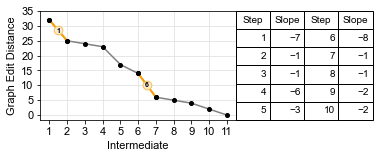

In [14]:
input_filename = "./matrices/gelsemine_synthia.npz"
highlight_steps = [1,6]
hl_only = True
step_labels = None

table_scale = (0.7,1.51)
gridlines = {"x":[1,3,5,7,9],"y":[0,5,10,15,20,25,30]}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/{output_title}.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, savename=savename)

### Waihoensene Synthia

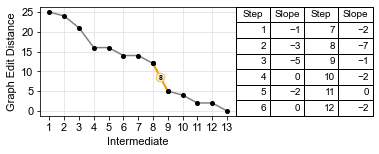

In [15]:
input_filename = "./matrices/waihoensene_synthia.npz"
highlight_steps = [8]
hl_only = True
step_labels = None

table_scale = (0.7,1.3)
gridlines = {"x":[1,3,5,7,9,11],"y":[0,5,10,15,20,25]}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/{output_title}.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, savename=savename)

### Literature routes

### 1. Welwitindolinone Baran

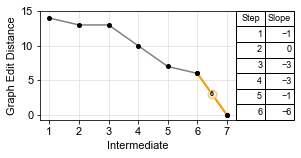

In [16]:
input_filename = "./matrices/welwitindolinone_baran.npz"

highlight_steps = [6]
hl_only = True
step_labels = None

table_scale = (0.3,1.3)
# table_scale=None

gridlines = {"x":range(7),"y":[0,5,10]}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/{output_title}.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines,
          savename=savename)

### 2. Frondosin B Danishefsky

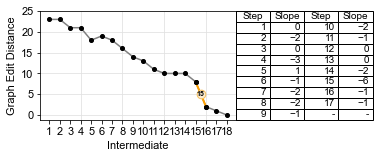

In [17]:
input_filename = "./matrices/frondosin_danishefsky.npz"
plt_title="Danishefsky Frondosin B"

highlight_steps = [15]
hl_only = True
step_labels = None

table_scale = (0.7,0.91)
# table_scale=None

gridlines = {"x":range(3,19,4),"y":range(0,25,5)}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/{output_title}.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, 
           savename=savename)

### 3. Englerin A Christmann 

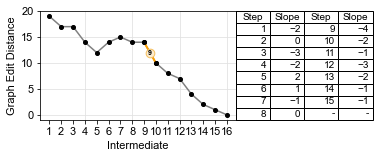

In [18]:
input_filename = "./matrices/englerin_christmann.npz"
plt_title="Christmann Englerin A"

highlight_steps = [9]
hl_only = True
step_labels = None

table_scale = (0.7,1.01)
# table_scale=None

gridlines = {"x":range(3,19,4),"y":range(0,20,5)}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/{output_title}.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, 
           savename=savename)

### 4. Englerin A Chain

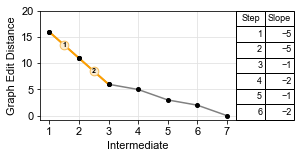

In [19]:
input_filename = "./matrices/englerin_chain.npz"
plt_title="Chain Englerin A"

highlight_steps = [1,2]
hl_only = True
step_labels = None

table_scale = (0.3,1.3)
# table_scale=None

gridlines = {"x":range(1,7,2),"y":range(0,20,5)}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/{output_title}.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, 
           savename=savename)

### 5. Strychnine MacMillan

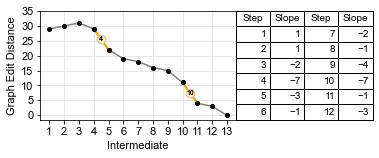

In [20]:
input_filename = "./matrices/strychnine_macmillan.npz"
plt_title="MacMillan Strychnine"

highlight_steps = [4,10]
hl_only = True
step_labels = None

table_scale = (0.7,1.3)
# table_scale=None

gridlines = {"x":range(1,13,2),"y":range(0,31,5)}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/{output_title}.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, 
           savename=savename)

### 6. Vanderwal Strychnine

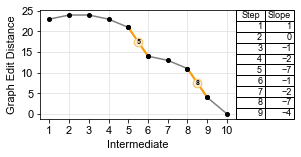

In [21]:
input_filename = "./matrices/strychnine_vanderwal.npz"
plt_title="Vanderwal Strychnine"

highlight_steps = [5,8]
hl_only = True
step_labels = None

table_scale = (0.3,0.91)
# table_scale=None

gridlines = {"x":range(1,11,2),"y":range(0,25,5)}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/SI_2/{output_title}.png"
# savename=None

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, 
           savename=savename)